In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (410, 615, 3)


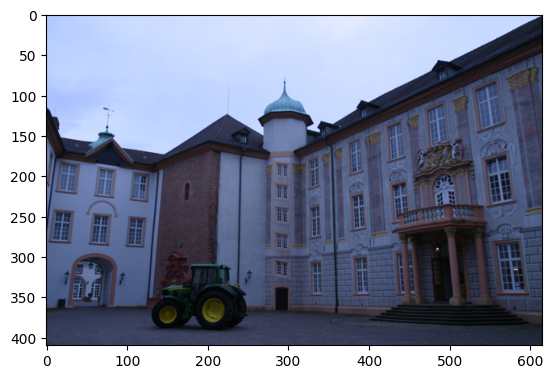

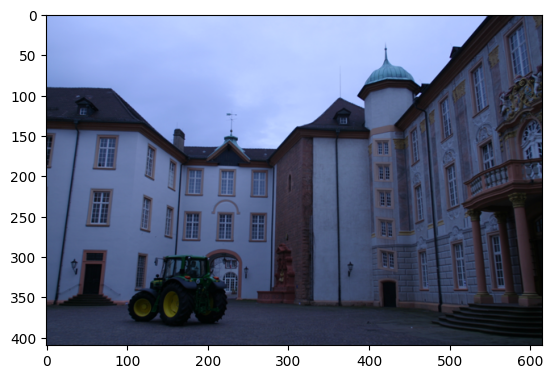

In [3]:
# load the images
im_left = cv2.imread('../data/0014_2.png')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('../data/0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

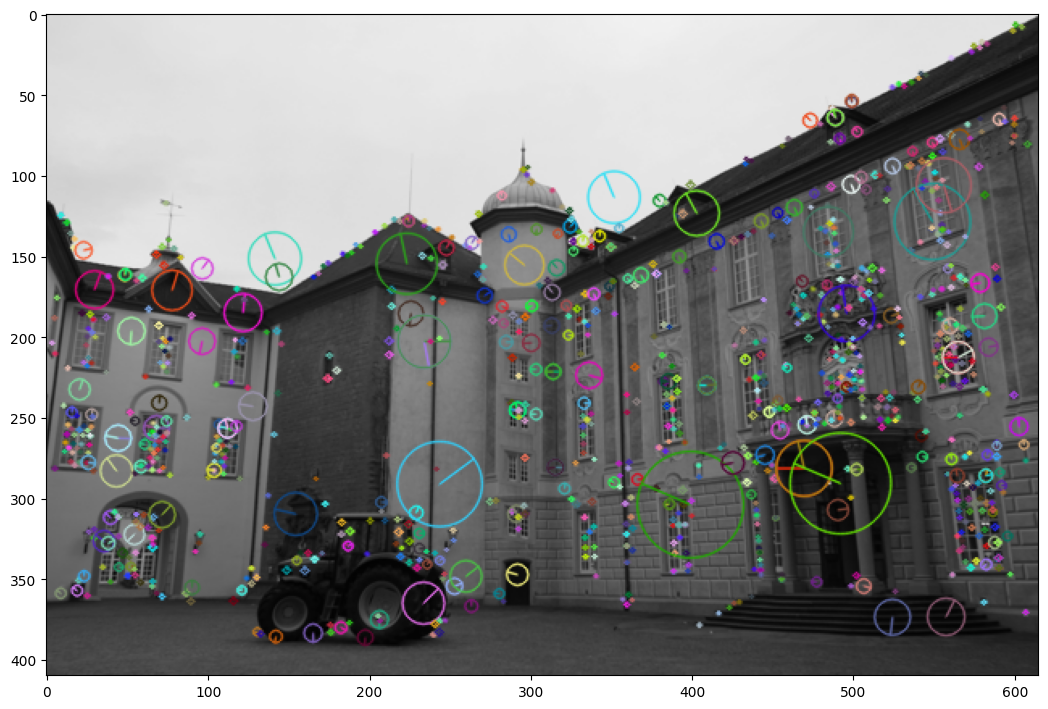

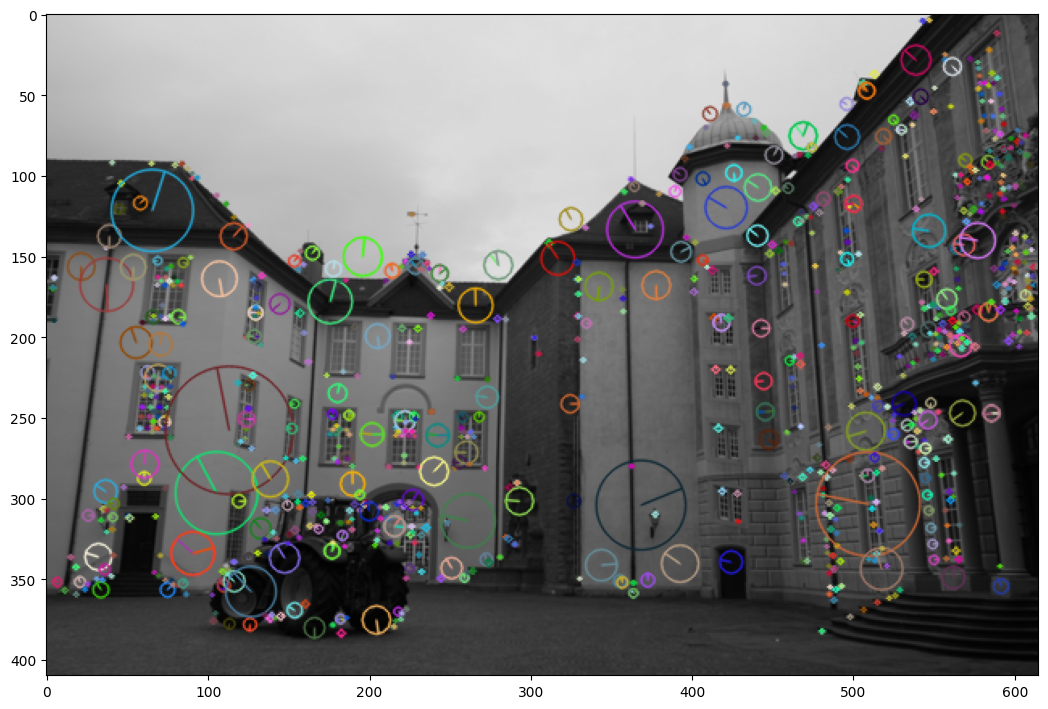

In [4]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 598


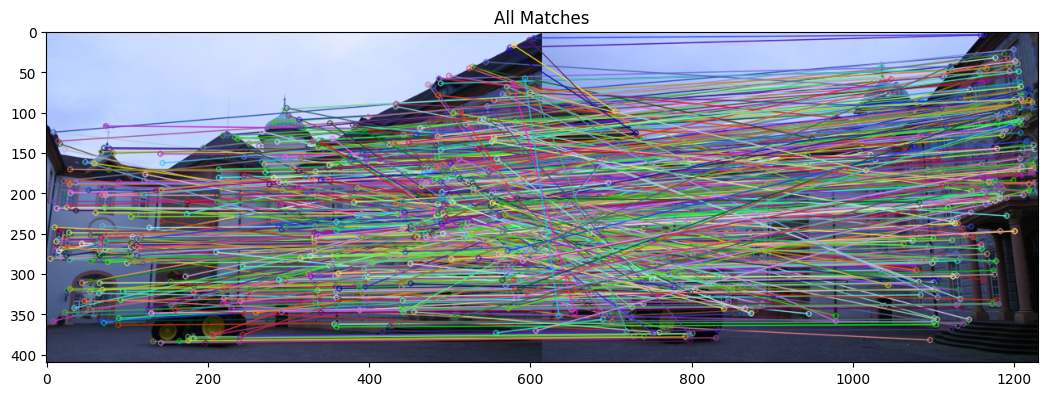

In [5]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)


In [6]:
""" Compute calibrated coordinates
"""

# For the satsok castle images
f1 = f2 = 552
u0 = 307.5
v0 = 205

K = np.array([[f1, 0, u0],
              [0, f2, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [7]:
from lse import least_squares_estimation

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

[[ 4.64678535e-02 -6.10102418e-02 -7.74621316e-02  4.41124640e-04
  -9.18575320e-01 -2.25187750e-01  2.84250979e-01  1.02889750e-01
  -4.73587606e-02]
 [-9.44310485e-03 -5.71696357e-04  3.81667685e-02 -6.70217571e-02
   2.55429366e-01  2.19004490e-02  5.41143011e-01  7.67964835e-01
  -2.13617286e-01]
 [ 3.22651375e-02 -6.55102114e-01  7.38360198e-01 -1.01656027e-01
  -5.19597008e-02  1.03543742e-01 -2.44625149e-02 -1.05854247e-02
   1.26042832e-02]
 [ 2.06909431e-03 -2.89599752e-02 -1.41376285e-02 -9.28235580e-02
   1.56843441e-01  3.77534249e-02  7.15402519e-01 -6.30195693e-01
  -2.35304891e-01]
 [ 1.16030116e-02  5.04813903e-03  5.00694336e-04 -2.66100054e-02
  -5.47478598e-02  8.21515771e-03 -3.20889529e-01 -2.09197692e-02
  -9.44806329e-01]
 [ 4.45011432e-02  9.76950272e-02 -1.19773014e-01 -6.57386635e-01
  -1.79939831e-01  7.10464563e-01 -3.93271417e-02  3.00795400e-02
   4.88152187e-02]
 [ 1.10852968e-01 -7.14645777e-01 -6.34760775e-01 -1.75543126e-01
   1.27336089e-01 -1.5103926

In [19]:
from ransac import ransac_estimator

# running this cell will take a while!!!

E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

KeyboardInterrupt: 

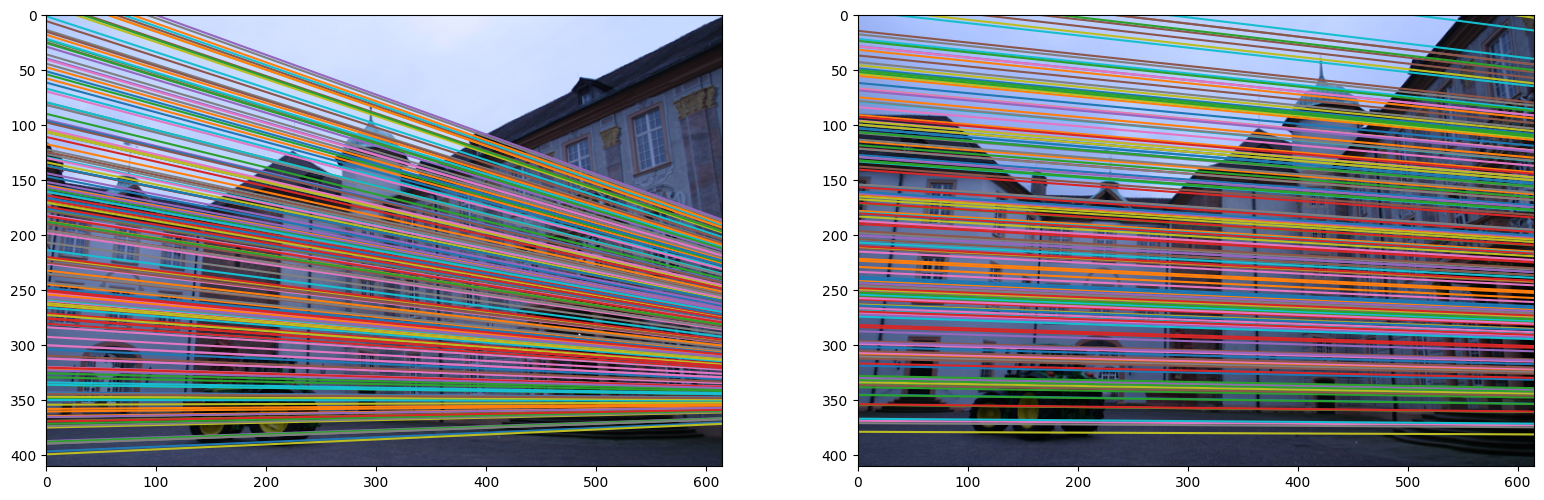

In [20]:
from plot_epi import plot_epipolar_lines

uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [45]:
from pose import pose_candidates_from_E

transform_candidates = pose_candidates_from_E(E_ransac)
print("transform_candidates", transform_candidates)
for c in transform_candidates:
  print(np.linalg.det(c['R']))

np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T

[-0.98430175 -0.05676988 -0.16711449]
transform_candidates [{'T': array([-0.98430175, -0.05676988, -0.16711449]), 'R': array([[ 0.89360484,  0.09991431,  0.43759288],
       [-0.09482893,  0.99492909, -0.03351987],
       [-0.438723  , -0.01154294,  0.89854821]])}, {'T': array([-0.98430175, -0.05676988, -0.16711449]), 'R': array([[ 0.68300324,  0.20108289,  0.70219103],
       [ 0.18576025, -0.97756899,  0.09925724],
       [ 0.70639911,  0.06264617, -0.705036  ]])}, {'T': array([0.98430175, 0.05676988, 0.16711449]), 'R': array([[ 0.89360484,  0.09991431,  0.43759288],
       [-0.09482893,  0.99492909, -0.03351987],
       [-0.438723  , -0.01154294,  0.89854821]])}, {'T': array([0.98430175, 0.05676988, 0.16711449]), 'R': array([[ 0.68300324,  0.20108289,  0.70219103],
       [ 0.18576025, -0.97756899,  0.09925724],
       [ 0.70639911,  0.06264617, -0.705036  ]])}]
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999998


array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [42]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

598
[[ 0.01428356  0.00211918]
 [ 0.010991    0.00044648]
 [ 0.03800351 -0.043672  ]]
[[-0.01766598  0.00146062]
 [ 0.00391439 -0.00600389]
 [ 0.03800351 -0.04359191]]
[[-0.01000196  0.00194747]
 [ 0.00072688 -0.00108204]
 [ 0.03800351 -0.0436454 ]]
[[ 0.01494353  0.00233026]
 [ 0.00323564  0.00485273]
 [ 0.03800351 -0.04361042]]
[[ 0.01715821  0.00233026]
 [-0.01216635  0.00485273]
 [ 0.03800351 -0.04361042]]
[[-0.0064241   0.00069972]
 [-0.00315401 -0.01131345]
 [ 0.03800351 -0.04341942]]
[[-0.00246806  0.00139487]
 [ 0.00524845 -0.00326932]
 [ 0.03800351 -0.04345788]]
[[ 0.01033317  0.00116408]
 [-0.00257896 -0.00523769]
 [ 0.03800351 -0.04341891]]
[[-0.00908273  0.00114813]
 [ 0.0038122  -0.00448441]
 [ 0.03800351 -0.04338304]]
[[-0.00908273  0.00114813]
 [ 0.0038122  -0.00448441]
 [ 0.03800351 -0.04338304]]
[[-0.00922154  0.00139637]
 [ 0.00129407 -0.00164465]
 [ 0.03800351 -0.043398  ]]
[[-0.01221874  0.00101577]
 [-0.00200838 -0.00504449]
 [ 0.03800351 -0.04333948]]
[[ 0.0069595

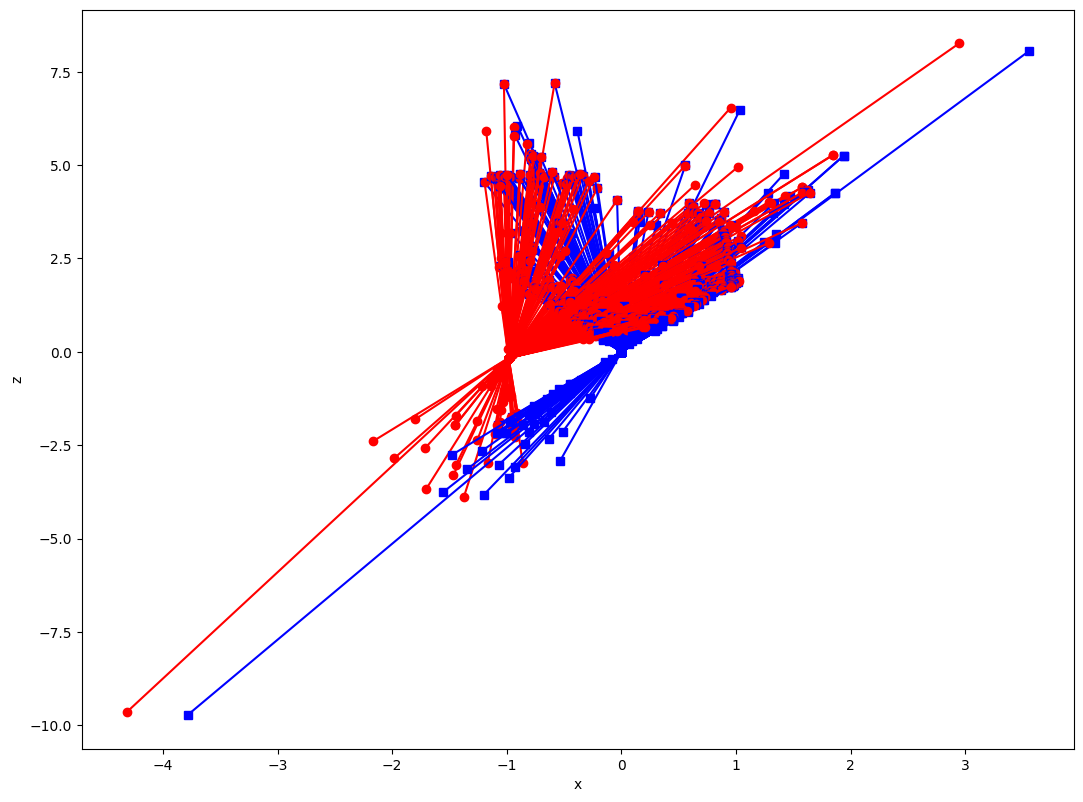

In [104]:
from recon3d import reconstruct3D 

P1, P2, T, R = reconstruct3D(transform_candidates, calibrated_1, calibrated_2)

plot_reconstruction(P1, P2, T, R)

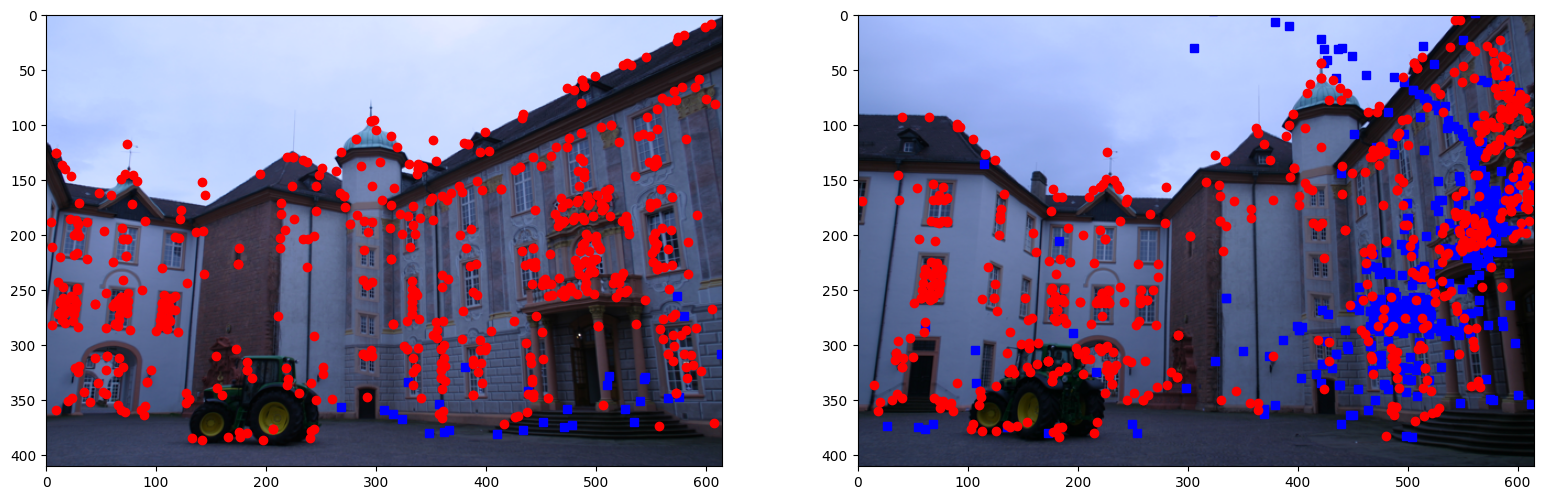

In [92]:
from show_reproj import show_reprojections

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)